In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [215]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import datetime
import json
import pyDOE
from smt.sampling_methods import LHS
import scipy.stats as sc
from itertools import chain
from scipy.stats import kurtosis, skew, ks_2samp
from datetime import timezone

In [ ]:
ft_freq_list = [50, 100, 150]
mm_pos_limit_list = [5000, 8000, 10000]
mm_rest_list = [12000, 36000]
total_vol_list = [180000, 240000, 300000, 360000]
ins_interval_list = [40, 80, 120, 160]
params_list = [(a,b,c,d,e) for a in ft_freq_list for b in mm_pos_limit_list for c in mm_rest_list for d in total_vol_list for e in ins_interval_list]
len(params_list)

In [216]:
import gzip
import pandas as pd
import numpy as np
from datetime import timezone
import datetime
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, ks_2samp
from statsmodels.tsa.stattools import acf
cme_format = '%Y%m%d%H%M%S%f'
dt = datetime.timedelta(hours=4)

In [217]:
from CMECalibration.distance_calc import get_historical_ret
ticker = "ESM0"
datestr = "20100506"
directory = 'D:/projects/data/XCME/2010/{0}/{1}/MD/XCME/'.format(datestr[-4:-2], datestr[-2:])
start = pd.to_datetime(datestr + '080000', format=cme_format)
end = pd.to_datetime(datestr + '123000', format=cme_format)
tick_size = 0.25
scale = 100
freq = '1S'
his_ret, close = get_historical_ret(directory+ticker+'.csv', cme_format, dt, scale, start, end, freq=freq)


In [218]:
res_directory = 'CME/Results/'
block_size = 1800
weights = np.array([1,1,5,10])
ll = 3
LAGS = list(chain(*[[x+i for i in range(ll)] for x in (30, 60, 90)]))
LAGS2 = list(chain(*[[x+i for i in range(ll)] for x in (1, 30, 60, 90)]))
print(LAGS, LAGS2)

[30, 31, 32, 60, 61, 62, 90, 91, 92] [1, 2, 3, 30, 31, 32, 60, 61, 62, 90, 91, 92]


In [219]:
from CMECalibration.moment_coverage_util import get_moment_coverage, get_confidence_interval, block_bootstrap_ind
hill_interval, vol_interval, acf_interval, acf2_interval = get_confidence_interval(his_ret, ll, LAGS, LAGS2, block_size=block_size)
his_intervals = {'hill': hill_interval, 'vol': vol_interval, 'acf': acf_interval, 'acf2': acf2_interval}
print(his_intervals)

{'hill': [0.05448719750339068, 0.13575396668971745], 'vol': [0.17501183092151223, 0.2101051330090974], 'acf': array([[-6.14241721e-03,  8.12221083e-03],
       [-1.27105872e-02,  8.33322953e-03],
       [ 3.41667282e-06,  1.44794842e-02]]), 'acf2': array([[ 0.02143729,  0.06029955],
       [-0.00781038,  0.01603887],
       [-0.00087011,  0.02412629],
       [ 0.00094036,  0.02767277]])}


In [220]:
opt_params = {'res_directory': res_directory, 'start':start, 'end':end, 'his_ret':his_ret, 'tick_size': tick_size, 'll':ll, 'LAGS':LAGS, 'LAGS2':LAGS2, 'weights': weights, 'freq': freq, 'interval': his_intervals}

In [ ]:
20100504: {'hill': [0.018874672890950458, 0.07320554777796338], 'vol': [0.1849469224019588, 0.24013447356637807], 'acf': array([[-0.00254957,  0.01010493],
       [-0.00482513,  0.00683708],
       [-0.01298686,  0.00129826]]), 'acf2': array([[0.05203287, 0.0821346 ],
       [0.00772899, 0.03499238],
       [0.01380017, 0.04988893],
       [0.00912584, 0.03873619]])}

## Moment specific p-value calculation

In [221]:
from CMECalibration.distance_calc import prepare_distance, get_synthetic_market_data_sim, get_simulated_ret

In [222]:
np.random.seed(1)
boots_dist_record = []
for _ in range(100):
    ret_ind = block_bootstrap_ind(len(his_ret), block_size=100)
    tmp_his_ret = his_ret[ret_ind]
    dist = prepare_distance(opt_params['his_ret'], tmp_his_ret, opt_params['LAGS'], opt_params['LAGS2'])
    boots_dist_record.append(np.sum(dist*weights))

In [223]:
print(np.quantile(boots_dist_record, 0.95))

0.18792746779550945


20100503: block size 100; seed 1; 0.2114; simulation runs: 60 <br>
20100504: block size 100; seed 1; 0.2300; simulation runs: 60 <br>
20100505: block size 100; seed 1; 0.1959; simulation runs: 12 <br>
20100506: block size 100; seed 1; 0.1879; simulation runs: 60 <br>

In [43]:

def get_fv_mv_value(data_path):
    fv = pd.read_csv('{0}/fundamental_value.csv'.format(data_path)).set_index('timestamp')
    fv.index = pd.to_datetime(fv.index, format=turquoise_datetime_format).floor('S')
    mv = pd.read_csv('{0}/momentum_value.csv'.format(data_path)).set_index('timestamp')
    mv.index = pd.to_datetime(mv.index, format=turquoise_datetime_format).floor('S')
    return fv.squeeze(), mv.squeeze()

In [24]:
turquoise_datetime_format = "%d-%b-%Y %H:%M:%S.%f"
tick_size = 0.25
datestr = '20100505'
start = pd.to_datetime(datestr + ' 08:00:00')
end = pd.to_datetime(datestr + ' 17:00:00')
run_list = sorted(os.listdir("D:/projects/simulator/Workflow/CME/Results"))
run_list = [x for x in run_list if x[0] == 'r']
print(len(run_list))

90


In [225]:

names = [x for x in os.listdir(opt_params['res_directory']) if 'run_' in x]
print(len(names))
tmp_dist = []
for n_ in names:
    data_path = opt_params['res_directory'] + n_
    sim_md = get_synthetic_market_data_sim(data_path)
    sim_ret = get_simulated_ret(sim_md, opt_params['start'], opt_params['end'], freq=opt_params['freq'])
    dist = prepare_distance(opt_params['his_ret'], sim_ret, opt_params['LAGS'], opt_params['LAGS2'])
    tmp_dist.append(np.sum(dist * opt_params['weights']))
print(np.round(np.array(tmp_dist), 4))


60
[0.161  0.1767 0.1582 0.1703 0.1732 0.1595 0.157  0.1977 0.216  0.1792
 0.1884 0.2037 0.1976 0.2073 0.1835 0.1974 0.2    0.1843 0.1872 0.2406
 0.1505 0.1669 0.2045 0.209  0.2425 0.215  0.1529 0.1991 0.1786 0.1529
 0.1333 0.2127 0.1587 0.1929 0.1708 0.166  0.1308 0.1883 0.191  0.209
 0.1918 0.1568 0.1876 0.1636 0.1984 0.1739 0.1503 0.1732 0.1785 0.2094
 0.1704 0.1829 0.1641 0.1636 0.2082 0.1676 0.1609 0.1775 0.1575 0.1707]


In [226]:
opt_params['weights']

array([ 1,  1,  5, 10])

In [227]:
from scipy import stats
stats.percentileofscore(tmp_dist, 0.1879)

61.666666666666664

In [133]:
np.std(s_ret) * np.sqrt(len(s_ret)*252) # Vol

0.23810200526904507

In [228]:
run_list = sorted(os.listdir("D:/projects/simulator/Workflow/CME/Results"))
run_list = [x for x in run_list if x[0] == 'r']
print(len(run_list))
moment_cover = np.array([0, 0] + [0 for _ in range(len(LAGS)//ll)] + [0 for _ in range(len(LAGS2)//ll)] + [0])
for sim in run_list:
    data_path = 'CME/Results/' + sim
    md = get_synthetic_market_data_sim(data_path)
    raw_mp = md['mp']
    raw_mp = raw_mp.dropna().loc[start:end]
    mp = raw_mp.resample('1S').last().fillna(method='ffill').dropna()
    close = mp.bfill().values
    s_ret = close[1:] / close[:-1] - 1
    
    sim_cover = get_moment_coverage(s_ret, his_intervals, ll, LAGS, LAGS2)
    moment_cover += np.array(sim_cover)
    print(moment_cover)
print(np.round(moment_cover / len(run_list), 4).tolist())

60
[1 1 1 1 0 1 1 1 1 0]
[2 2 2 2 0 2 2 2 1 0]
[3 3 3 3 1 3 3 3 1 0]
[4 3 4 4 2 4 4 3 2 0]
[5 4 5 5 2 5 5 4 3 0]
[6 4 6 6 2 6 6 5 3 0]
[7 4 7 7 2 7 7 5 4 0]
[8 5 7 8 3 8 8 6 5 0]
[9 5 7 9 3 9 9 6 5 0]
[10  6  8 10  4 10 10  7  6  1]
[11  7  9 11  4 11 11  8  7  1]
[12  7 10 12  4 12 12  9  7  1]
[13  8 11 13  5 13 13  9  7  1]
[14  8 12 14  5 14 14 10  8  1]
[15  8 13 15  6 15 15 11  9  1]
[16  8 14 16  7 16 16 12  9  1]
[17  8 15 17  7 17 17 12 10  1]
[18  9 16 18  7 18 18 13 11  1]
[19  9 17 19  7 19 19 14 12  1]
[20  9 18 20  7 20 20 15 12  1]
[21 10 19 21  8 21 21 15 13  1]
[22 11 20 22  9 22 22 16 13  1]
[23 12 21 23  9 23 23 16 13  1]
[24 13 22 24  9 24 24 17 13  1]
[25 14 23 25  9 24 25 17 13  1]
[26 14 24 26  9 25 26 18 13  1]
[27 14 25 27  9 26 27 19 14  1]
[28 14 26 28 10 27 28 20 14  1]
[29 15 27 29 11 28 29 21 15  2]
[30 15 28 30 12 29 30 22 16  2]
[31 16 29 31 13 30 31 23 17  3]
[32 16 29 32 14 31 32 23 17  3]
[33 17 30 33 15 32 33 24 17  3]
[34 18 31 34 16 33 34 25 18  4]

In [25]:
# 20100506
print(np.array(acf_cover) / len(run_list), np.array(acf2_cover) / len(run_list), hill_cover / len(run_list), vol_cover / len(run_list), total_cover / len(run_list))

[0.   1.   1.   0.98] [0.76666667 0.99       0.93       0.83666667] 0.8666666666666667 0.82 0.36666666666666664


In [26]:
# Bootstrap moment coverage ratio
np.random.seed(12)
block_size = 600

acf_cover = [0 for _ in range(4)]
acf2_cover = [0 for _ in range(4)]
hill_cover = 0
vol_cover = 0
total_cover = 0

for _ in run_list:
    total = 0
    ret_ind = block_bootstrap_ind(len(his_ret), block_size)
    s_ret = his_ret[ret_ind]
    sim_vol = np.std(s_ret) * np.sqrt(len(s_ret)*252)
    if sim_vol > vol_interval[0] and sim_vol < vol_interval[1]:
        total += 1
        vol_cover += 1
    
    sim_hill = hill_estimator(s_ret)
    if sim_hill > hill_interval[0] and sim_hill < hill_interval[1]:
        total += 1
        hill_cover += 1
    values = acf(s_ret, fft=True, nlags=100)
    sim_acf = values[LAGS].reshape((len(LAGS)//ll,ll)).mean(axis=1)
    values = acf(s_ret**2, fft=True, nlags=100)
    sim_acf2 = values[LAGS2].reshape((len(LAGS2)//ll,ll)).mean(axis=1)
    for i in range(4):
        if sim_acf[i] > acf_interval[i, 0] and sim_acf[i] < acf_interval[i, 1]:
            total += 1
            acf_cover[i] += 1
        if sim_acf2[i] > acf2_interval[i, 0] and sim_acf2[i] < acf2_interval[i, 1]:
            total += 1
            acf2_cover[i] += 1
    if (total == 10):
        total_cover += 1
    print(acf_cover, acf2_cover, hill_cover, vol_cover, sim_vol, total_cover)
print(np.array(acf_cover) / len(run_list), np.array(acf2_cover) / len(run_list), hill_cover / len(run_list), vol_cover / len(run_list), total_cover / len(run_list))

[1, 1, 1, 1] [1, 1, 1, 1] 1 1 0.2223260134802292 1
[2, 2, 2, 2] [2, 2, 1, 2] 2 2 0.20535309076405892 1
[3, 3, 3, 3] [3, 2, 1, 3] 2 3 0.2076323457998741 1
[4, 4, 4, 4] [4, 3, 2, 3] 3 4 0.2207408829500348 1
[5, 5, 5, 5] [5, 4, 2, 4] 4 4 0.2026019201781645 1
[6, 6, 6, 6] [6, 5, 3, 5] 5 5 0.21196295404629475 2
[7, 7, 7, 7] [7, 5, 4, 5] 6 6 0.21278216446223497 2
[8, 8, 8, 8] [8, 6, 5, 6] 7 7 0.2164001137040083 3
[9, 9, 9, 9] [9, 7, 6, 7] 8 8 0.2175460621197297 4
[10, 10, 10, 10] [10, 8, 7, 8] 9 9 0.21072641543460033 5
[11, 11, 11, 11] [11, 9, 8, 9] 10 10 0.22534740442477919 6
[12, 12, 12, 12] [12, 10, 9, 10] 11 11 0.22636955930306668 7
[13, 13, 13, 13] [13, 11, 10, 11] 12 12 0.23521441233764054 8
[14, 14, 14, 14] [14, 12, 11, 12] 13 13 0.2133368614238474 9
[15, 15, 15, 15] [15, 13, 12, 13] 14 14 0.219176173342822 10
[16, 16, 16, 16] [16, 13, 13, 14] 15 14 0.20058673133949032 10
[17, 17, 17, 17] [17, 14, 14, 15] 16 15 0.20528197050523192 11
[18, 18, 18, 18] [18, 15, 15, 16] 17 16 0.225652803

[127, 132, 131, 132] [112, 114, 114, 117] 124 125 0.21760462811099973 76
[128, 133, 132, 133] [113, 115, 115, 118] 124 125 0.23814558748750075 76
[129, 134, 133, 134] [114, 116, 116, 119] 125 126 0.23602252923595313 77
[130, 135, 134, 135] [115, 117, 117, 120] 126 126 0.20340206716025716 77
[131, 136, 135, 136] [115, 117, 118, 121] 127 127 0.22139289940153228 77
[132, 137, 136, 137] [116, 118, 119, 122] 127 128 0.2071580454039583 77
[133, 138, 137, 138] [117, 119, 120, 123] 127 129 0.23251188207887388 77
[134, 139, 138, 139] [118, 119, 121, 124] 127 129 0.20414618011174082 77
[135, 140, 139, 140] [119, 120, 122, 124] 128 130 0.23225545350541316 77
[136, 141, 139, 141] [119, 121, 123, 125] 129 131 0.22598513010794957 77
[137, 142, 140, 142] [120, 122, 124, 126] 130 132 0.21584422130076802 78
[138, 143, 141, 143] [121, 122, 125, 126] 130 133 0.23489095268765292 78
[139, 144, 142, 144] [122, 123, 126, 127] 131 133 0.23767044323519204 78
[140, 145, 143, 145] [123, 124, 127, 128] 132 134 0.

In [48]:
50*1024/200

256.0

In [21]:
data_path = 'CME/Results/run_00002'
turquoise_datetime_format = "%d-%b-%Y %H:%M:%S.%f"
tick_size = 0.25
datestr = '20100506'
start = pd.to_datetime(datestr + ' 08:00:00')
end = pd.to_datetime(datestr + ' 17:00:00')
md = get_synthetic_market_data(data_path, tick_size=tick_size)
fv, mv = get_fv_mv_value(data_path)
l1B, l1S, raw_mp, spread, orders, trades, market_orders, lob_l1, pos = md['l1B'], md['l1S'], md['mp'], md['spread'], md['orders'], md['trades'], md['market_orders'], md['lob_l1'], md['pos']
raw_mp = raw_mp.dropna().loc[start:end]
mp = raw_mp.resample('1S').apply(lambda i: i[-1] if len(i) > 0 else np.nan).fillna(method='ffill').dropna()

In [ ]:
turquoise_datetime_format = "%d-%b-%Y %H:%M:%S.%f"
tick_size = 0.25
datestr = '20100506'
start = pd.to_datetime(datestr + ' 08:00:00')
end = pd.to_datetime(datestr + ' 17:00:00')
image = 0
for (ft_freq, mm_pos_limit, mm_rest, total_vol, ins_interval) in params_list:
    model_params['FT_params']['ft_freq'] = ft_freq
    model_params['MM_params']['mm_pos_limit'] = mm_pos_limit
    model_params['MM_params']['mm_rest'] = mm_rest
    model_params['INS_params']['total_vol'] = total_vol
    model_params['INS_params']['ins_interval'] = ins_interval
    
    save_target_params(model_params, save_path='CME/model_params.json')
    flag = run_simulation()
    assert flag == 0, "Error when running simulation!"
    
    for sim in ['run_00000', 'run_00001', 'run_00002']:
        data_path = 'CME/Results/' + sim
        md = get_synthetic_market_data(data_path, tick_size=tick_size)
        fv, mv = get_fv_mv_value(data_path)
        raw_mp = md['mp']
        raw_mp = raw_mp.dropna().loc[start:end]
        mp = raw_mp.resample('1S').apply(lambda i: i[-1] if len(i) > 0 else np.nan).fillna(method='ffill').dropna()
        
        left, right = 18000, 38000
        fig, ax = plt.subplots(figsize=(12,4))
        ax.plot(mp.iloc[left:right], 'g', alpha=0.9, label='simulated mid price')
        ax.plot(fv.iloc[left:right], 'b', label='fundamental value')
        ax.plot(mid.iloc[left:right], 'r', alpha=0.7, label='real mid price')
        ax.set_title('ft_freq: %d, mm_pos_limit: %d, mm_rest: %d, total_vol: %d, ins_interval: %d'%(ft_freq, mm_pos_limit, mm_rest, total_vol, ins_interval))
        ax.legend(loc='best')
        plt.show()
        fig.savefig('images/%s.png'%(str(image)+sim))
    
    image += 1
        
        

## 20100506 
## moment coverage ratio
[0, 300, 300, 294] [230, 297, 279, 251] 260 246 110 <br>
print(np.array(acf_cover) / len(run_list), np.array(acf2_cover) / len(run_list), hill_cover / len(run_list), vol_cover / len(run_list), total_cover / len(run_list)) <br>
[0.   1.   1.   0.98] [0.76666667 0.99       0.93       0.83666667] 0.8666666666666667 0.82 0.36666666666666664 <br>

## Bootstrap results:
[294, 300, 300, 300] [295, 299, 295, 300] 281 283 259 <br>
[0.98 1.   1.   1.  ] [0.98333333 0.99666667 0.98333333 1.] 0.9366666666666666 0.9433333333333334 0.8633333333333333

In [49]:
def forward(a):
    return np.log(a) +5

def inverse(a):
    return np.exp(a-5)

In [50]:
a = np.array([3,4,5,6,7,100,200,300,400,500])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


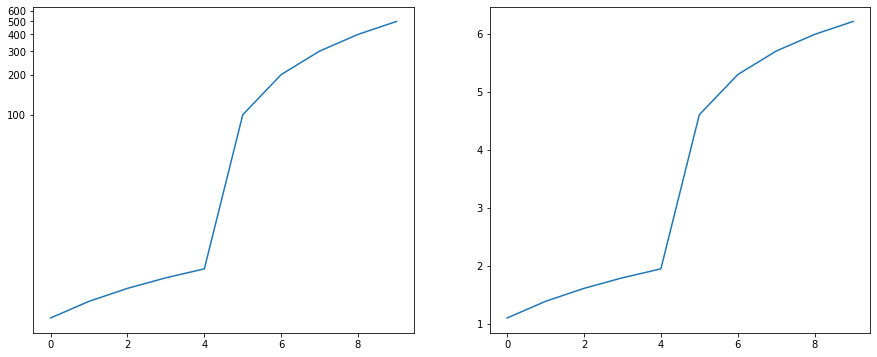

In [51]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].plot(a)
ax[0].set_yscale('function', functions=(forward, inverse))
ax[1].plot(np.log(a))
plt.show()